In [109]:
# instalação das Libs
!pip install yfinance
!pip install crewai
!pip install 'crewai[tools]'
!pip install langchain
!pip install langchain-openai
!pip install langchain-community
!pip install duckduckgo-search
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00


In [110]:
# importação das libs
import json
import os
from datetime import datetime

import yfinance as yf

from crewai import Agent, Task, Crew, Process

from langchain.tools import Tool
from langchain_openai import ChatOpenAI
from langchain_community.tools import DuckDuckGoSearchResults

import streamlit as st

from IPython.display import Markdown

In [60]:
# Criando Yashoo Finance Tool
def fetch_stock_price(ticket):
    stock = yf.download(ticket, start="2023-08-08", end="2024-08-08")
    return stock

yahoo_finance_tool = Tool(
    name = "Yahoo Finance Tool",
    description = "Fetches stock prices for {ticket} from the last year about a specific stock from Yahoo Finance API",
    func = lambda ticket:  fetch_stock_price(ticket)
)

In [61]:
response = yahoo_finance_tool.run("AAPL")

[*********************100%%**********************]  1 of 1 completed


In [62]:
print(response)

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-08  179.690002  180.270004  177.580002  179.800003  178.643387   
2023-08-09  180.869995  180.929993  177.009995  178.190002  177.043777   
2023-08-10  179.479996  180.750000  177.600006  177.970001  176.825150   
2023-08-11  177.320007  178.619995  176.550003  177.789993  176.884857   
2023-08-14  177.970001  179.690002  177.309998  179.460007  178.546371   
...                ...         ...         ...         ...         ...   
2024-08-01  224.369995  224.479996  217.020004  218.360001  218.107544   
2024-08-02  219.149994  225.600006  217.710007  219.860001  219.605804   
2024-08-05  199.089996  213.500000  196.000000  209.270004  209.028061   
2024-08-06  205.300003  209.990005  201.070007  207.229996  206.990402   
2024-08-07  206.899994  213.639999  206.389999  209.820007  209.577423   

               Volume  
Date         

# Importação do modelo

In [87]:
# importando OPENAI LLM - GPT
os.environ["OPENAI_API_KEY"] = "API_KEY"
llm = ChatOpenAI(model="gpt-3.5-turbo")

# Criação dos Agents

In [88]:
stockPriceAnalyst = Agent(
    role= "Senior stock price Analyst",
    goal="Find the {ticket} stock price and analyses trends",
    backstory="""You're highly experienced in analyzing the price of an specific stock
    and make predictions about its future price.""",
    verbose=True,
    llm= llm,
    max_iter= 5,
    memory= True,
    tools=[yahoo_finance_tool],
    allow_delegation=False
)

In [89]:
# Criação da tarefa do agent
getStockPrice = Task(
    description= "Analyze the stock {ticket} price history and create a trend analyses of up, down or sideways",
    expected_output = """" Specify the current trend stock price - up, down or sideways.
    eg. stock= 'APPL, price UP'
""",
    agent= stockPriceAnalyst
)

In [90]:
# Importando a tool de Search
search_tool = DuckDuckGoSearchResults(backend='news', num_results=10)

In [91]:
newsAnalyst = Agent(
    role= "Stock News Analyst",
    goal="""Create a short summary of the market news related to the stock {ticket} company. Specify the current trend - up, down or sideways with
    the news context. For each request stock asset, specify a numbet between 0 and 100, where 0 is extreme fear and 100 is extreme greed.""",
    backstory="""You're highly experienced in analyzing the market trends and news and have tracked assest for more then 10 years.

    You're also master level analyts in the tradicional markets and have deep understanding of human psychology.

    You understand news, theirs tittles and information, but you look at those with a health dose of skepticism.
    You consider also the source of the news articles.
    """,
    verbose=True,
    llm= llm,
    max_iter= 10,
    memory= True,
    tools=[search_tool],
    allow_delegation=False
)

In [92]:
# Criação da tarefa do agent
get_news = Task(
    description= f"""Take the stock and always include BTC to it (if not request).
    Use the search tool to search each one individually.

    The current date is {datetime.now()}.

    Compose the results into a helpfull report""",
    expected_output = """"A summary of the overall market and one sentence summary for each request asset.
    Include a fear/greed score for each asset based on the news. Use format:
    <STOCK ASSET>
    <SUMMARY BASED ON NEWS>
    <TREND PREDICTION>
    <FEAR/GREED SCORE>
""",
    agent= newsAnalyst
)

In [93]:
stockAnalystWrite = Agent(
    role = "Senior Stock Analyts Writer",
    goal= """"Analyze the trends price and news and write an insighfull compelling and informative 3 paragraph long newsletter based on the stock report and price trend. """,
    backstory= """You're widely accepted as the best stock analyst in the market. You understand complex concepts and create compelling stories
    and narratives that resonate with wider audiences.

    You understand macro factors and combine multiple theories - eg. cycle theory and fundamental analyses.
    You're able to hold multiple opinions when analyzing anything.
""",
    verbose = True,
    llm=llm,
    max_iter = 5,
    memory=True,
    allow_delegation = True
)

In [94]:
# Criação da tarefa do agent
writeAnalyses = Task(
    description = """Use the stock price trend and the stock news report to create an analyses and write the newsletter about the {ticket} company
    that is brief and highlights the most important points.
    Focus on the stock price trend, news and fear/greed score. What are the near future considerations?
    Include the previous analyses of stock trend and news summary.
""",
    expected_output= """"An eloquent 3 paragraphs newsletter formated as markdown in an easy readable manner. It should contain:

    - 3 bullets executive summary
    - Introduction - set the overall picture and spike up the interest
    - main part provides the meat of the analysis including the news summary and fead/greed scores
    - summary - key facts and concrete future trend prediction - up, down or sideways.
""",
    agent = stockAnalystWrite,
    context = [getStockPrice, get_news]
)

In [95]:
crew = Crew(
    agents = [stockPriceAnalyst, newsAnalyst, stockAnalystWrite],
    tasks = [getStockPrice, get_news, writeAnalyses],
    verbose = True,
    process= Process.hierarchical,
    full_output=True,
    share_crew=False,
    manager_llm=llm,
    max_iter=30
)

In [96]:
results = crew.kickoff(inputs={'ticket':'AAPL'})

 [2024-08-21 14:25:28][DEBUG]: == Working Agent: Crew Manager
 [2024-08-21 14:25:28][INFO]: == Starting Task: Analyze the stock AAPL price history and create a trend analyses of up, down or sideways


> Entering new CrewAgentExecutor chain...
I need to delegate the task of analyzing the stock AAPL price history and creating a trend analysis to the Senior stock price Analyst. They have the expertise to handle this task effectively.

Action:
Delegate work to coworker

Action Input:
{
    "task": "Analyze the stock AAPL price history and create a trend analysis",
    "context": "I need you to analyze the historical price data of AAPL and determine if the current trend is up, down, or sideways. Please provide a detailed analysis based on the data available.",
    "coworker": "Senior stock price Analyst"
}


> Entering new CrewAgentExecutor chain...


[*********************100%%**********************]  1 of 1 completed

I need to use the Yahoo Finance Tool to fetch the historical stock prices of AAPL and analyze the trend to provide a detailed analysis.

Action:
Yahoo Finance Tool

Action Input:
{"tool_input": "AAPL"}
 

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-08-08  179.690002  180.270004  177.580002  179.800003  178.643387   
2023-08-09  180.869995  180.929993  177.009995  178.190002  177.043777   
2023-08-10  179.479996  180.750000  177.600006  177.970001  176.825150   
2023-08-11  177.320007  178.619995  176.550003  177.789993  176.884857   
2023-08-14  177.970001  179.690002  177.309998  179.460007  178.546371   
...                ...         ...         ...         ...         ...   
2024-08-01  224.369995  224.479996  217.020004  218.360001  218.107544   
2024-08-02  219.149994  225.600006  217.710007  219.860001  219.605804   
2024-08-05  199.089996  213.500000  196.000000  209.270

Final Answer:
Based on the historical price data of AAPL from August 8, 2023, to August 7, 2024, the stock price trend has shown fluctuations. The stock price has experienced both highs and lows during this period. However, it appears that the overall trend may be sideways with some volatility. Further analysis and comparison with additional data points would be necessary to confirm this trend.

> Finished chain.
 

Based on the historical price data of AAPL from August 8, 2023, to August 7, 2024, the stock price trend has shown fluctuations. The stock price has experienced both highs and lows during this period. However, it appears that the overall trend may be sideways with some volatility. Further analysis and comparison with additional data points would be necessary to confirm this trend.

Final Answer: stock= 'AAPL, price sideways'

> Finished chain.
 [2024-08-21 14:25:35][DEBUG]: == [Crew Manager] Task output: stock= 'AAPL, price sideways'


 [2024-08-21 14:25:35][DEBUG]: == Work

In [105]:
Markdown(results.raw)

# Apple Inc. (AAPL) Newsletter

### Executive Summary:
- AAPL stock has shown resilience amidst market volatility.
- Positive news includes beating expectations for Q3, while negative news includes market sell-off.
- Fear/greed score for AAPL is currently neutral.

### Introduction:
In a market filled with uncertainties, AAPL stands out as a beacon of stability. Despite facing challenges like Warren Buffet's sell-off and market turbulence, AAPL has managed to maintain its position with grace and poise.

### Analysis:
The recent news surrounding AAPL has been a mix of highs and lows. On one hand, AAPL exceeded expectations for its fiscal third quarter, displaying robust performance. On the other hand, the market sell-off has cast a shadow of doubt. However, AAPL's ability to trade sideways speaks volumes about its strength in the face of adversity.

The fear/greed score for AAPL is currently neutral, indicative of a delicate balance between positive and negative influences. This equilibrium suggests that investors are cautiously optimistic about AAPL's future trajectory.

### Summary:
In conclusion, AAPL is expected to continue its sideways movement in the short term. However, if positive news continues to outweigh negative sentiment, there is a strong possibility of an upward trend. Investors should keep a close eye on the developments in the market to make informed decisions regarding AAPL's stock.

--- 

This newsletter provides a comprehensive analysis of AAPL's current standing in the market, offering insights into its performance and future prospects.

In [111]:
with st.sidebar:
    st.header('Enter the Stock to Research')

    with st.form(key='research_form'):
        topic = st.text_input("Select the ticket")
        submit_button = st.form_submit_button(label = "Run Research")
if submit_button:
    if not topic:
        st.error("Please fill the ticket field")
    else:
        results= crew.kickoff(inputs={'ticket': topic})

        st.subheader("Results of research:")
        st.write(results['final_output'])

2024-08-21 14:39:36.835 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-08-21 14:39:36.837 Session state does not function when running a script without `streamlit run`


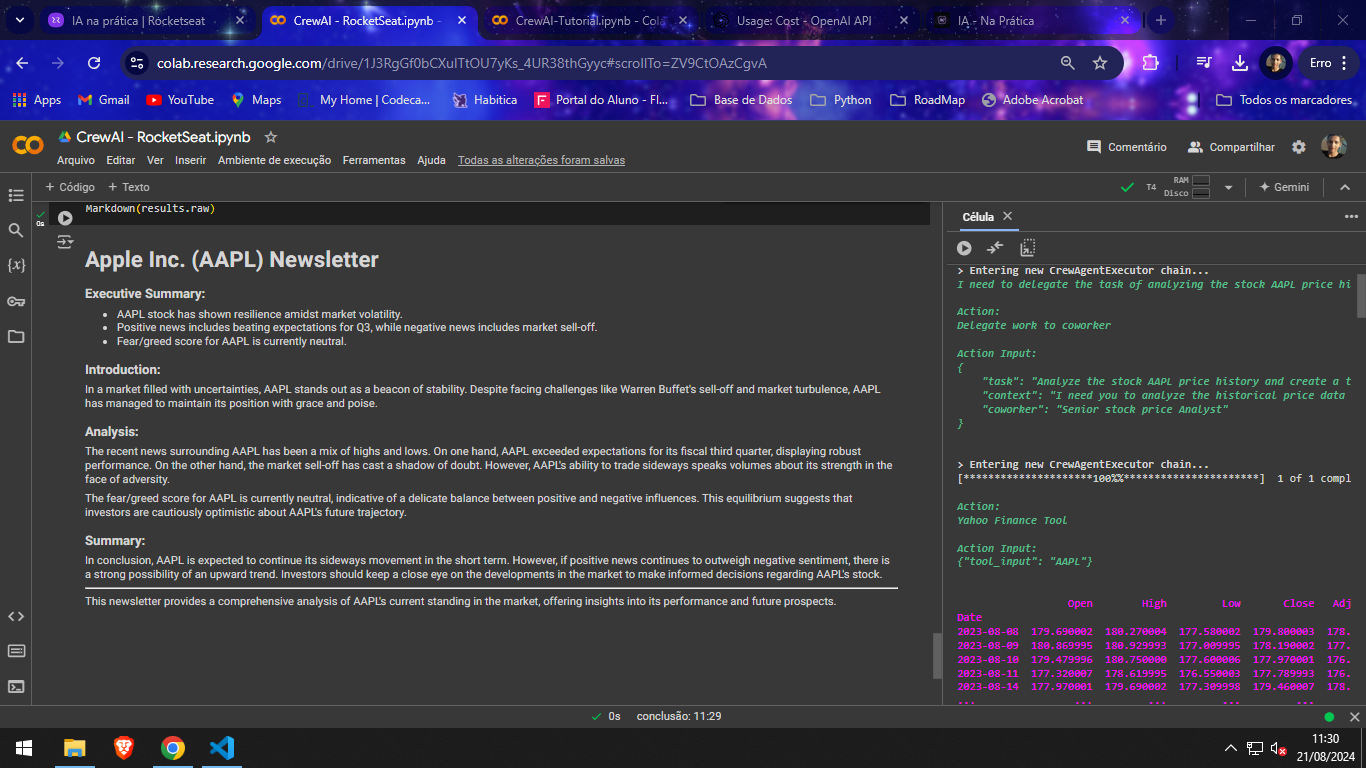